In [10]:
import os

import numpy as np
import pandas as pd
import optuna
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

from data import *


SEED = 662
DATA_DIR = "processed"

data = remove_boring_columns(
    transform_all_house(combined_transformed_train_with_num_pov)
)

/Users/borisleung/Desktop/STA841Kaggle/data.py:282: FutureWarning: using <built-in method join of str object at 0x105009770> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df[fathers_in_house_mask]["psu_hh_idcode"].str.split("_").str[:-1].agg("_".join)
/Users/borisleung/Desktop/STA841Kaggle/data.py:251: FutureWarning: using <built-in method join of str object at 0x105009770> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df[mothers_in_house_mask]["psu_hh_idcode"].str.split("_").str[:-1].agg("_".join)


In [ ]:
from models import *


def get_linear_svc(trial, seed, X_train, y_train):
    model, calibrated_model = suggest_linear_svc(trial, seed)
    model.fit(X_train, y_train)
    calibrated_model.fit(X_train, y_train)
    return calibrated_model


def get_kernel_svc(trial, seed, X_train, y_train):
    model = suggest_kernel_svc(trial, seed)
    model.fit(X_train, y_train)
    return model


storage = f"sqlite:///svm.db"
X, y, y_binarized = (
    data.drop(Y_COLUMNS + ["num_pov"], axis=1),
    data["num_pov"],
    data[Y_COLUMNS],
)

In [ ]:
import logging
import sys

from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split

from data import get_preprocessor

MAX_ITER = 20000


def load_objective(
    X: pd.DataFrame,
    y: pd.DataFrame,
    y_binarized: pd.DataFrame,
    get_trained_model: callable,
):
    X.replace(VALID_NULL, np.nan, inplace=True)

    def objective(trial: optuna.Trial):
        chi2_threshold = trial.suggest_int("chi2_threshold", 2, 100)
        cv = trial.suggest_int("cv", 3, 5)
        imputer_strategy = trial.suggest_categorical(
            "imputer_strategy", ["mean", "median", "most_frequent"]
        )

        train_losses, valid_losses, valid_loss_shift, n_iters = [], [], [], []
        X_train, X_valid, y_train, y_valid, y_train_binarized, y_valid_binarized = (
            train_test_split(X, y, y_binarized, test_size=1 / cv, random_state=SEED)
        )  # lazy, just do 1 round of cv

        # add pov means aggregated by psu
        aggregated_pov_train_data = pd.concat(
            [X_train["psu_hh_idcode"], y_train], axis=1
        )
        aggregated_pov_train_data[["psu", "hh", "idcode"]] = aggregated_pov_train_data[
            "psu_hh_idcode"
        ].str.split("_", expand=True)
        df_mean = aggregated_pov_train_data.groupby("psu")["num_pov"].mean()
        X_train_means = pd.merge(
            aggregated_pov_train_data,
            df_mean,
            on="psu",
            how="left",
            suffixes=("", "_mean"),
        )["num_pov_mean"]
        X_train_means.replace(np.nan, X_train_means.mean(), inplace=True)

        X_valid[["psu", "hh", "idcode"]] = X_valid["psu_hh_idcode"].str.split(
            "_", expand=True
        )
        X_valid_means = pd.merge(
            X_valid,
            df_mean,
            on="psu",
            how="left",
            suffixes=("", "_mean"),
        )["num_pov"]
        X_valid_means.replace(np.nan, X_valid_means.mean(), inplace=True)
        X_valid_means.rename("num_pov_mean", inplace=True)

        preprocessor = get_preprocessor(
            imputer_strategy=[
                "most_frequent",
                "most_frequent",
                imputer_strategy,
                imputer_strategy,
            ],
            remainder="drop",
        )

        X_train_processed = preprocessor.fit_transform(X_train)
        selector = SelectPercentile(chi2, percentile=chi2_threshold)
        X_train = selector.fit_transform(X_train_processed, y_train)
        X_train = np.column_stack([X_train, X_train_means])

        X_valid = preprocessor.transform(X_valid)
        X_valid = selector.transform(X_valid)
        X_valid = np.column_stack([X_valid, X_valid_means])

        model, calibrated_model = suggest_linear_svc(
            trial, max_iter=MAX_ITER, seed=SEED
        )
        model.fit(X_train, y_train)
        calibrated_model.fit(X_train, y_train)

        train_losses.append(
            log_loss(y_train_binarized, calibrated_model.predict_proba(X_train))
        )

        y_pred = calibrated_model.predict_proba(X_valid)
        # for column_index in [
        #     column for column in range(10) if column not in model.classes_
        # ]:
        #     y_pred = np.insert(y_pred, column_index - 1, 0, axis=1)

        valid_losses.append(log_loss(y_valid_binarized, y_pred))
        valid_loss_shift.append(valid_losses[-1] - train_losses[-1])
        n_iters.append(model.n_iter_)

        mean_valid_loss = np.mean(valid_losses)
        trial.set_user_attr(
            "selected_columns",
            X_train_processed.columns[selector.get_support()].values.tolist(),
        )
        trial.set_user_attr("n_iter", np.mean(n_iters))
        trial.set_user_attr("train_loss", np.mean(train_losses))
        trial.set_user_attr("valid_loss_shift", np.mean(valid_loss_shift))
        return mean_valid_loss

    return objective


optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
optuna.logging.set_verbosity(optuna.logging.WARNING)
storage = f"sqlite:///svm.db"
study_name = "linear-svc4(w/ psu means)"
study = optuna.create_study(
    direction="minimize", storage=storage, study_name=study_name, load_if_exists=True
)
study.optimize(
    load_objective(X, y, y_binarized, get_linear_svc),
    n_trials=1000,
    n_jobs=-1,
    show_progress_bar=True,
)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['edu_q31' 'edu_q49' 'edu_q60']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['edu_q31' 'edu_q49' 'edu_q60']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['edu_q31' 'edu_q49' 'edu_q60']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packa

In [ ]:
import logging
import sys

from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split

from data import get_preprocessor

MAX_ITER = 20000


def load_objective(
    X: pd.DataFrame,
    y: pd.DataFrame,
    y_binarized: pd.DataFrame,
    get_trained_model: callable,
):
    X.replace(VALID_NULL, np.nan, inplace=True)

    def objective(trial: optuna.Trial):
        chi2_threshold = trial.suggest_int("chi2_threshold", 2, 100)
        cv = trial.suggest_int("cv", 3, 5)
        imputer_strategy = trial.suggest_categorical(
            "imputer_strategy", ["mean", "median", "most_frequent"]
        )

        train_losses, valid_losses, valid_loss_shift, n_iters = [], [], [], []
        X_train, X_valid, y_train, y_valid, y_train_binarized, y_valid_binarized = (
            train_test_split(X, y, y_binarized, test_size=1 / cv, random_state=SEED)
        )  # lazy, just do 1 round of cv

        # add pov means aggregated by psu
        aggregated_pov_train_data = pd.concat(
            [X_train["psu_hh_idcode"], y_train], axis=1
        )
        aggregated_pov_train_data[["psu", "hh", "idcode"]] = aggregated_pov_train_data[
            "psu_hh_idcode"
        ].str.split("_", expand=True)
        df_mean = aggregated_pov_train_data.groupby("psu")["num_pov"].mean()
        X_train_means = pd.merge(
            aggregated_pov_train_data,
            df_mean,
            on="psu",
            how="left",
            suffixes=("", "_mean"),
        )["num_pov_mean"]
        X_train_means.replace(np.nan, X_train_means.mean(), inplace=True)

        X_valid[["psu", "hh", "idcode"]] = X_valid["psu_hh_idcode"].str.split(
            "_", expand=True
        )
        X_valid_means = pd.merge(
            X_valid,
            df_mean,
            on="psu",
            how="left",
            suffixes=("", "_mean"),
        )["num_pov"]
        X_valid_means.replace(np.nan, X_valid_means.mean(), inplace=True)
        X_valid_means.rename("num_pov_mean", inplace=True)

        preprocessor = get_preprocessor(
            imputer_strategy=[
                "most_frequent",
                "most_frequent",
                imputer_strategy,
                imputer_strategy,
            ],
            remainder="drop",
        )

        X_train_processed = preprocessor.fit_transform(X_train)
        selector = SelectPercentile(chi2, percentile=chi2_threshold)
        X_train = selector.fit_transform(X_train_processed, y_train)
        X_train = np.column_stack([X_train, X_train_means])

        X_valid = preprocessor.transform(X_valid)
        X_valid = selector.transform(X_valid)
        X_valid = np.column_stack([X_valid, X_valid_means])

        model = get_trained_model(
            trial, seed=SEED, X_train=X_train, y_train=y_train - 1
        )

        train_losses.append(log_loss(y_train_binarized, model.predict_proba(X_train)))

        y_pred = model.predict_proba(X_valid)
        # for column_index in [
        #     column for column in range(10) if column not in model.classes_
        # ]:
        #     y_pred = np.insert(y_pred, column_index - 1, 0, axis=1)

        valid_losses.append(log_loss(y_valid_binarized, y_pred))
        valid_loss_shift.append(valid_losses[-1] - train_losses[-1])
        n_iters.append(model.n_iter_)

        mean_valid_loss = np.mean(valid_losses)
        trial.set_user_attr(
            "selected_columns",
            X_train_processed.columns[selector.get_support()].values.tolist(),
        )
        trial.set_user_attr("n_iter", np.mean(n_iters))
        trial.set_user_attr("train_loss", np.mean(train_losses))
        trial.set_user_attr("valid_loss_shift", np.mean(valid_loss_shift))
        return mean_valid_loss

    return objective


X, y, y_binarized = (
    data.drop(Y_COLUMNS + ["num_pov"], axis=1),
    data["num_pov"],
    data[Y_COLUMNS],
)
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_name = "kernel-svc4(w/ psu means)"
study = optuna.create_study(
    direction="minimize", storage=storage, study_name=study_name, load_if_exists=True
)
study.optimize(
    load_objective(X, y, y_binarized, get_kernel_svc),
    n_trials=1000,
    n_jobs=-1,
    show_progress_bar=True,
)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['edu_q31' 'edu_q49' 'edu_q60']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['edu_q31' 'edu_q49' 'edu_q60']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['edu_q31' 'edu_q49' 'edu_q60']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/sit

In [4]:
aggregated_pov_entire_train_data = pd.concat(
    [data["psu_hh_idcode"], data["num_pov"]], axis=1
)
aggregated_pov_entire_train_data[["psu", "hh", "idcode"]] = (
    aggregated_pov_entire_train_data["psu_hh_idcode"].str.split("_", expand=True)
)
df_mean = aggregated_pov_entire_train_data.groupby("psu")["num_pov"].mean()
X_entire_train_mean = pd.merge(
    aggregated_pov_entire_train_data,
    df_mean,
    on="psu",
    how="left",
    suffixes=("", "_mean"),
)["num_pov_mean"]
X_entire_train_mean.replace(np.nan, X_entire_train_mean.mean(), inplace=True)

combined_test[["psu", "hh", "idcode"]] = combined_test["psu_hh_idcode"].str.split(
    "_", expand=True
)
X_test_means = pd.merge(
    combined_test,
    df_mean,
    on="psu",
    how="left",
    suffixes=("", "_mean"),
)["num_pov"]
X_test_means.replace(np.nan, X_test_means.mean(), inplace=True)
X_test_means.rename("num_pov_mean", inplace=True)

0       4.400000
1       4.400000
2       4.400000
3       4.000000
4       4.571429
          ...   
1329    4.400000
1330    5.142857
1331    5.200000
1332    5.200000
1333    5.200000
Name: num_pov_mean, Length: 1334, dtype: float64

In [11]:
pd.DataFrame(X_entire_train_mean).describe(), pd.DataFrame(X_test_means).describe()

(       num_pov_mean
 count   5337.000000
 mean       4.582912
 std        1.289238
 min        1.000000
 25%        3.666667
 50%        4.571429
 75%        5.400000
 max        8.142857,
        num_pov_mean
 count   1334.000000
 mean       4.553616
 std        1.276536
 min        1.000000
 25%        3.666667
 50%        4.600000
 75%        5.400000
 max        8.142857)

In [9]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectPercentile, chi2

linear_study = optuna.create_study(
    direction="minimize",
    storage=storage,
    study_name="linear-svc4(w/ psu means)",
    load_if_exists=True,
)
linear_best_trial = linear_study.best_trial
linear_chi2_threshold = linear_best_trial.params["chi2_threshold"]

linear_preprocessor = get_preprocessor(
    imputer_strategy=[
        "most_frequent",
        "most_frequent",
        linear_best_trial.params["imputer_strategy"],
        linear_best_trial.params["imputer_strategy"],
    ],
    remainder="drop",
)
X_processed = linear_preprocessor.fit_transform(X)
selector = SelectPercentile(chi2, percentile=linear_chi2_threshold)
X_processed = selector.fit_transform(X_processed, y)
X_processed = np.column_stack([X_processed, X_entire_train_mean])

C = linear_best_trial.params["C"]
penalty = linear_best_trial.params["penalty"]
intercept_scaling = linear_best_trial.params["intercept_scaling"]
final_model = LinearSVC(
    C=C,
    penalty=penalty,
    intercept_scaling=intercept_scaling,
    max_iter=MAX_ITER * 5,
    random_state=SEED,
)
final_model.fit(X_processed, y)
calibration_method = linear_best_trial.params["calibration_method"]
final_calibrated_model = CalibratedClassifierCV(
    final_model, cv="prefit", method=calibration_method
)
final_calibrated_model.fit(X_processed, y)

final_y_train_pred = final_calibrated_model.predict_proba(X_processed)

log_loss(y_binarized, final_y_train_pred)

[I 2024-11-19 14:16:36,303] Using an existing study with name 'linear-svc4(w/ psu means)' instead of creating a new one.


1.6475942390594838

<Axes: >

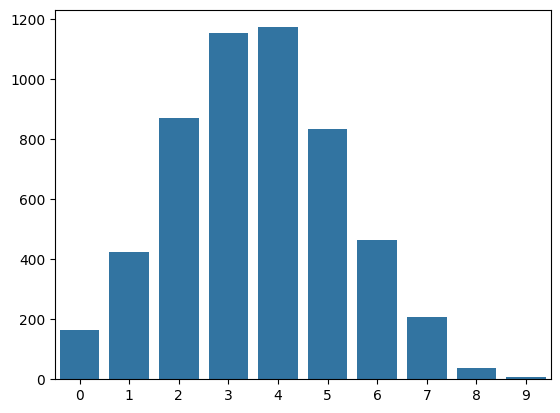

In [11]:
sns.barplot(final_y_train_pred.sum(axis=0))

In [ ]:
combined_transformed_train

Submission file saved as linear-svc-2.csv


/Users/borisleung/Desktop/STA841Kaggle/data.py:282: FutureWarning: using <built-in method join of str object at 0x104ee1770> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df[fathers_in_house_mask]["psu_hh_idcode"].str.split("_").str[:-1].agg("_".join)
/Users/borisleung/Desktop/STA841Kaggle/data.py:251: FutureWarning: using <built-in method join of str object at 0x104ee1770> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df[mothers_in_house_mask]["psu_hh_idcode"].str.split("_").str[:-1].agg("_".join)
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [8, 11, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py

<Axes: >

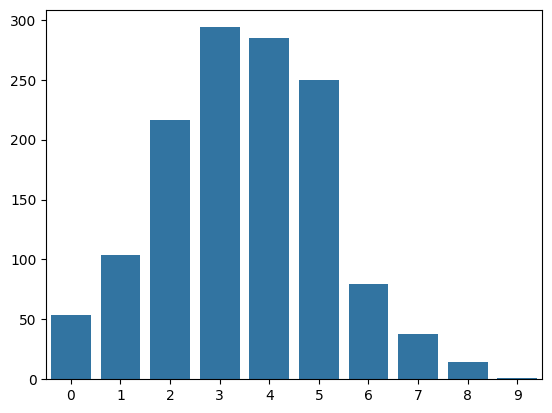

In [14]:
import seaborn as sns

from data import generate_submission, combined_test

X_submissions = remove_boring_columns(transform_all_house(combined_transformed_test))
X_submissions_scaled = linear_preprocessor.transform(X_submissions)
X_submissions_scaled = selector.transform(X_submissions_scaled)
X_submissions_scaled = np.column_stack([X_submissions_scaled, X_test_means])
final_y_pred = final_calibrated_model.predict_proba(X_submissions_scaled)

generate_submission(final_y_pred, "linear-svc")
sns.barplot(final_y_pred.sum(axis=0))

In [15]:
kernel_study = optuna.create_study(
    direction="minimize",
    storage=storage,
    study_name="kernel-svc4(w/ psu means)",
    load_if_exists=True,
)
kernel_best_trial = kernel_study.best_trial
kernel_chi2_threshold = kernel_best_trial.params["chi2_threshold"]
kernel_final_preprocessor = get_preprocessor(
    imputer_strategy=[
        "most_frequent",
        "most_frequent",
        kernel_best_trial.params["imputer_strategy"],
        kernel_best_trial.params["imputer_strategy"],
    ],
    remainder="drop",
)
X_processed = kernel_final_preprocessor.fit_transform(X)
kernel_selector = SelectPercentile(chi2, percentile=kernel_chi2_threshold)
X_processed = kernel_selector.fit_transform(X_processed, y)
X_processed = np.column_stack([X_processed, X_entire_train_mean])

kernel = kernel_best_trial.params["kernel"]
C = kernel_best_trial.params["C"]
if kernel == "poly":
    degree = kernel_best_trial.params["degree"]
    final_model = SVC(
        C=C,
        kernel=kernel,
        degree=degree,
        max_iter=MAX_ITER * 5,
        random_state=SEED,
        probability=True,
    )
else:
    final_model = SVC(
        C=C, kernel=kernel, max_iter=MAX_ITER * 5, random_state=SEED, probability=True
    )
final_model.fit(X_processed, y)

final_y_train_pred = final_model.predict_proba(X_processed)

log_loss(y_binarized, final_y_train_pred)

/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


1.5595220713401532

In [ ]:
combined_transformed_train

In [ ]:
combined_transformed_test

/Users/borisleung/Desktop/STA841Kaggle/data.py:282: FutureWarning: using <built-in method join of str object at 0x104ee1770> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df[fathers_in_house_mask]["psu_hh_idcode"].str.split("_").str[:-1].agg("_".join)
/Users/borisleung/Desktop/STA841Kaggle/data.py:251: FutureWarning: using <built-in method join of str object at 0x104ee1770> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df[mothers_in_house_mask]["psu_hh_idcode"].str.split("_").str[:-1].agg("_".join)
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [8, 11, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/borisleung/anaconda3/envs/sta841kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py

Submission file saved as kernel-svc-2.csv


<Axes: >

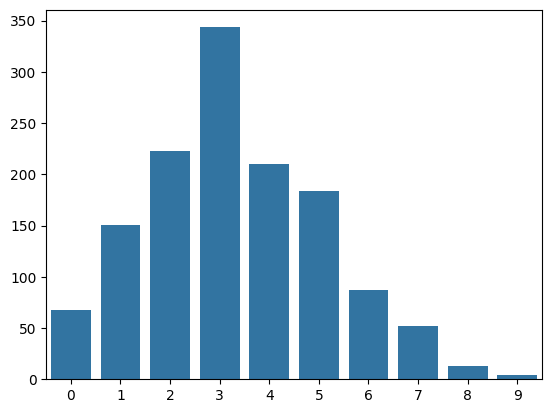

In [16]:
from data import generate_submission, combined_test

X_submissions = remove_boring_columns(
    transform_all_house(combined_transformed_test)
).drop(columns=Y_COLUMNS + ["psu_hh_idcode"])
X_submissions_scaled = kernel_final_preprocessor.transform(X_submissions)
X_submissions_scaled = kernel_selector.transform(X_submissions_scaled)
X_submissions_scaled = np.column_stack([X_submissions_scaled, X_test_means])
final_y_pred = final_model.predict_proba(X_submissions_scaled)

generate_submission(final_y_pred, "kernel-svc")
sns.barplot(final_y_pred.sum(axis=0))